**What about data?**
- 일반적으로 이미지, 텍스트, 오디오, 비디오 데이터를 다룰 땐 표준 Python 패키지 이용하여 NumPy 배열로 불러오고, 그 후 배열을 `torch.*Tensor`로 변환
  - 이미지: Pillow, OpenCV
  - 오디오: SciPy, LibROSA
  - 텍스트: Python, Cython, NLTK, SpaCy
- 특히 영상 분야를 위한 `torchvision`에는 ImageNet이나 CIFAR10, MNIST 등과 같이 일반적으로 사용하는 데이터셋을 위한 data loader(`torchvision.datasets`, `torch.utils.data.DataLoader`)가 포함되어 있음
- CIFAR10: 3x32x32 이미지

**Training an image classifier**
1. `torchvision` 사용하여 CIFAR10 training/test dataset 불러오고 normalize
2. CNN 정의
3. Loss function 정의
4. Training data 사용하여 CNN 학습
5. Test data 사용하여 CNN 검사

**1. Load and normalize CIFAR10**

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# torchvision dataset의 output은 [0, 1] 범위를 갖는 PILImage -> [-1, 1] 범위로 정규화된 Tensor로 변환

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


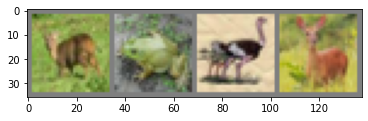

deer frog bird deer 


In [4]:
# train dataset 몇 개 확인해보기

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(''.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

**2. Define a Covolutional Neural Network**

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
  
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1) # batch를 제외한 모든 차원 flatten
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
  
net = Net()

**3. Define a Loss function and optimizer**
- Cross-Entropy loss와 momentum 값을 갖는 SGD 사용

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

**4. Train the network**
- Data를 반복해서 CNN에 입력으로 제공하고 optimize

In [8]:
for epoch in range(2):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data

    # gradient 매개변수 0으로 초기화
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # 통계 출력
    running_loss += loss.item()
    if i % 2000 == 1999:
      print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
      running_loss = 0.0

print("Finished Training")

[1,  2000] loss: 2.210
[1,  4000] loss: 1.898
[1,  6000] loss: 1.686
[1,  8000] loss: 1.609
[1, 10000] loss: 1.531
[1, 12000] loss: 1.488
[2,  2000] loss: 1.396
[2,  4000] loss: 1.384
[2,  6000] loss: 1.351
[2,  8000] loss: 1.328
[2, 10000] loss: 1.313
[2, 12000] loss: 1.271
Finished Training


In [9]:
# 학습된 모델 저장
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

**5. Test the network on the test data**
- 지금까지 training dataset을 2회 반복하여 CNN을 학습시킴
- CNN이 예측한 output과 ground-truth를 비교하는 방식으로 확인
- 만약 예측이 맞다면 샘플을 correct predictions 목록에 삽입

In [10]:
# 저장한 모델 불러오기
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [11]:
correct = 0
total = 0

# 학습 중이 아니므로 output에 대한 gradient 계산할 필요 없음
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images) # CNN에 image 통과시켜 output 계산
    _, predicted = torch.max(outputs.data, 1) # 가장 높은 energy를 갖는 class를 정답으로 선택
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 51 %


In [12]:
# 어떤 것을 더 잘 분류하고 어떤 것을 잘 분류하지 못했는지 확인

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predictions = torch.max(outputs, 1)
    for label, prediction in zip(labels, predictions):
      if label == prediction:
        correct_pred[classes[label]] += 1
      total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
  accuracy = 100 * float(correct_count) / total_pred[classname]
  print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 44.0 %
Accuracy for class: car   is 64.8 %
Accuracy for class: bird  is 35.0 %
Accuracy for class: cat   is 26.5 %
Accuracy for class: deer  is 58.2 %
Accuracy for class: dog   is 38.8 %
Accuracy for class: frog  is 58.8 %
Accuracy for class: horse is 80.1 %
Accuracy for class: ship  is 62.1 %
Accuracy for class: truck is 46.7 %


**GPU에서 학습하기**
- Tensor를 GPU에 이동했던 것처럼, 신경망도 GPU로 옮길 수 있음

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device) # 재귀적으로 모든 모듈의 매개변수와 버퍼를 CUDA tensor로 변경
inputs, labels = data[0].to(device), data[1].to(device) # 각 단계에서 input, target도 GPU로 보내야 함